In [1]:
import sys
import os
import shutil
import json
import numpy as np

current_directory = os.getcwd()
path_components = current_directory.split(os.path.sep)
new_directory = os.path.sep.join(path_components[:-1])
sys.path.append(new_directory)

## Post processing framework

#### Simulation Name

In [2]:
simulation_name = 'Main'
simulation_folder = 'tests'

results_dir = os.path.sep.join(path_components[:-2])
results_path = os.path.join(results_dir,'.results',simulation_folder,simulation_name)
results_path = os.path.join(results_dir,'code','results',simulation_name)

main_path = os.path.join(results_dir,'code')
shutil.copyfile(os.path.join(results_path,simulation_name+'.py'), os.path.join(main_path,'S_temp.py'))
print(main_path)
print(results_path)

/home/martinachondo/PINN/code
/home/martinachondo/PINN/code/results/Main


In [3]:
folder_name = 'S_temp'
folder_path = os.path.join(main_path,'results',folder_name)

from S_temp import simulation

simulation.create_simulation()
print(simulation.domain_properties)



 <<INFO>> Starting NanoShaper 0.7.8
 <<INFO>> Loading atoms....
 <<INFO>> Read 27 atoms
 <<INFO>> Geometric baricenter ->  -0.136 0.5195 0.4945
 <<INFO>> Grid is 111
 <<INFO>> MAX 5.364 6.0195 5.9945
 <<INFO>> MIN -5.636 -4.9805 -5.0055
 <<INFO>> Perfil 90 %
 <<INFO>> Rmaxdim 10.065
 <<INFO>> Allocating memory...ok!
 <<INFO>> Initialization completed
 <<INFO>> Adjusting self intersection grid 
 <<INFO>> Self intersection grid is (before) 7
 <<INFO>> Self intersection grid is 4
 <<INFO>> Allocating self intersection grid....ok!
 <<INFO>> Computing alpha shape complex....ok!
 <<INFO>> Checking 0 probes for self intersections...ok!
 <<INFO>> Surface build-up time.. 0 [s]
 <<INFO>> Probe Radius value 1.4
 <<INFO>> Number of ses cells -> 117
 <<INFO>> Number of del_point cells -> 20
 <<INFO>> Number of regular del_edge cells -> 55
 <<INFO>> Number of singular del_edge cells -> 0
 <<INFO>> Number of regular del_facet cells -> 34
 <<INFO>> Number of singular del_facet cells -> 4
 <<INFO>> U

In [4]:
Iter = 10
simulation.load_model(folder_path,results_path,Iter, save=False)
Post = simulation.Post

OpenMesh not available
No module named 'openmesh'


In [5]:
df = Post.save_values_file(save=False)
print(json.dumps(df, indent=4))

{
    "Gsolv_value": "2545.660",
    "L2_continuity_u": "3.122e-01",
    "L2_continuity_du": "1.451e-01",
    "Loss_XPINN": "4.040e+00",
    "Loss_NN1": "3.813e+00",
    "Loss_NN2": "2.062e+00"
}


In [6]:
Post.PDE.get_solvation_energy(Post.XPINN.model)

1465.9475188529552

In [16]:
Post.plot_aprox_analytic(value='react')

AttributeError: 'Postprocessing' object has no attribute 'plot_aprox_analytic'

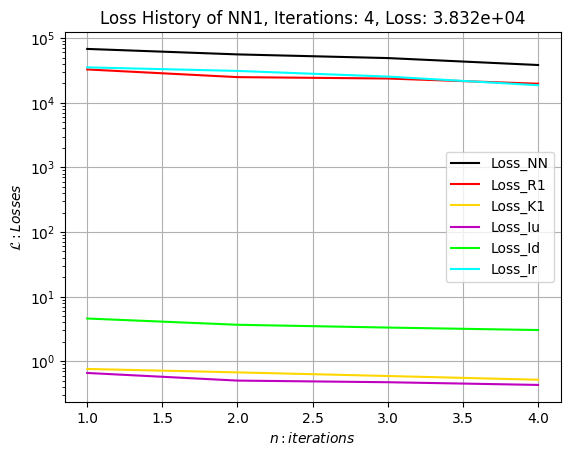

In [ ]:
Post.plot_loss_history(domain=1)

#### Computations

In [14]:
import bempp.api

u_interface,_,_ = Post.PDE.get_phi_interface(*Post.NN)
u_interface = u_interface.flatten()
_,du_1,du_2 = Post.PDE.get_dphi_interface(*Post.NN)
du_1 = du_1.flatten()
du_2 = du_2.flatten()
du_1_interface = (du_1+du_2*Post.NN[1].PDE.epsilon/Post.NN[0].PDE.epsilon)/2

phi = bempp.api.GridFunction(Post.PDE.space, coefficients=u_interface)
dphi = bempp.api.GridFunction(Post.PDE.space, coefficients=du_1_interface)

phi_q = Post.PDE.slp_q * dphi - Post.PDE.dlp_q * phi

slp_aprox = Post.PDE.slp_q * dphi
dlp_aprox = Post.PDE.dlp_q * phi

In [15]:
print('slp',slp_aprox)
print('dlp', dlp_aprox)

slp [[-0.04577357]]
dlp [[-0.00114817]]


In [16]:
Rs = np.linalg.norm(Post.PDE.mesh.mol_verts, axis=1)

u_interface = Post.PDE.analytic_Born_Ion(Rs)
du_1_interface = Post.PDE.analytic_Born_Ion_du(Rs)

phi = bempp.api.GridFunction(Post.PDE.space, coefficients=u_interface)
dphi = bempp.api.GridFunction(Post.PDE.space, coefficients=du_1_interface)

slp_an = Post.PDE.slp_q * dphi
dlp_an = Post.PDE.dlp_q * phi

In [17]:
print('slp',slp_an)
print('dlp', dlp_an)

slp [[-0.07938546]]
dlp [[-0.00094506]]


In [18]:
def get_Gsolv(slp,dlp):
  phi_q = slp - dlp
  G_solv = 0.5*np.sum(Post.PDE.qs * phi_q).real
  G_solv *= Post.PDE.to_V*Post.PDE.qe*Post.PDE.Na*(10**-3/4.184) 
  return G_solv

In [19]:
print('aprox',get_Gsolv(slp_aprox,dlp_aprox))
print('an',get_Gsolv(slp_an,dlp_an))

aprox -93.10722575405698
an -163.65945134158008


In [20]:
print('ap-an',get_Gsolv(slp_aprox,dlp_an))
print('an-ap',get_Gsolv(slp_an,dlp_aprox))

ap-an -93.53099959788352
an-ap -163.23567749775356


### Mesh

In [8]:
mol_mesh = Post.mesh.mol_mesh

In [20]:
X_plot = dict()
X_plot['Inner Domain'] = Post.mesh.region_meshes['R1'].vertices
X_plot['Inner Domain Sample'] = Post.mesh.region_meshes['R1'].get_dataset().numpy()

X_plot['Charges'] = Post.mesh.prior_data['Q1'].numpy()

X_plot['Interface'] = Post.mesh.region_meshes['I'].vertices
X_plot['Interface Sample'] = Post.mesh.region_meshes['I'].get_dataset().numpy()

X_plot['Outer Domain'] = Post.mesh.region_meshes['R2'].vertices
X_plot['Outer Domain Sample'] = Post.mesh.region_meshes['R2'].get_dataset().numpy()

X_plot['Outer Border'] = Post.mesh.region_meshes['D2'].vertices
X_plot['Outer Border Sample'] = Post.mesh.region_meshes['D2'].get_dataset().numpy()

In [29]:
s = mol_mesh.contains(X_plot['Inner Domain Sample'])
st = 0
sf = 0
for i in range(len(s)):
    if s[i]==True:
        st+=1
    else:
        sf+=1
print(st,sf)

12604 326


In [25]:
X_plot['Inner Domain'][~s]

array([[-1.03100002,  3.8440001 ,  3.13700008],
       [-0.56199998, -0.041     , -3.59299994],
       [-0.83399999,  0.243     , -3.53600001],
       ...,
       [-1.03799999, -2.454     , -0.067     ],
       [ 1.046     , -2.24000001, -0.066     ],
       [-2.17600012, -0.30700001, -2.12800002]])

In [28]:
mol_mesh.contains([[-1.03100002,  3.8440001 ,  3.13700008]])

array([False])

In [36]:
X_plot['Inner Domain Sample'][~s]

array([], shape=(0, 3), dtype=float32)

In [5]:
Post.mesh.R_mol

5.61922

In [6]:
Post.mesh.R_max_dist

5.9695745

In [7]:
np.linalg.norm(Post.mesh.centroid)

0.9602528

In [23]:
X_plot['Inner Domain']

array([[-1.03100002,  3.8440001 ,  3.13700008],
       [-1.43861133,  3.56253363,  2.88424426],
       [-0.92146109,  3.61931988,  2.59856082],
       ...,
       [-1.03799999, -2.454     , -0.067     ],
       [ 1.046     , -2.24000001, -0.066     ],
       [-2.17600012, -0.30700001, -2.12800002]])

In [24]:
help(mol_mesh.contains)

Help on method contains in module trimesh.base:

contains(points) method of trimesh.base.Trimesh instance
    Given an array of points determine whether or not they
    are inside the mesh. This raises an error if called on a
    non-watertight mesh.
    
    Parameters
    ------------
    points : (n, 3) float
      Points in cartesian space
    
    Returns
    ---------
    contains : (n, ) bool
      Whether or not each point is inside the mesh

